In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
    
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : b7DwzW3h 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

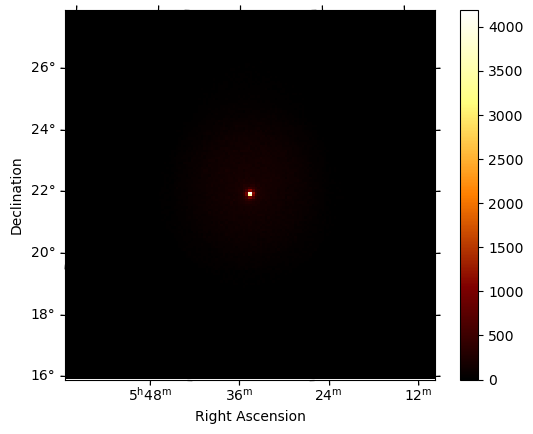

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [6]:
shift = +0.1
delta_tilt = 0.08
n = 24
tilt = delta_tilt/n 

N = 130
sigma_a = 0.1
sigma_i = tilt

save = True
save_flux = True




In [7]:
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass


0
shift:, [0.05462737], tilt: [-0.00072976]
8.56929506624945e-13   8.433845667744161e-14   2.2575567825779963   0.06387391690757808   0.9985717385949222   0.0020643062886245354   0.0011484325473984994   0.001964431185633944   
index
amplitude
1
shift:, [-0.16721091], tilt: [6.83025107e-05]
1.1632944953944996e-12   1.2512410816586074e-13   2.252218406412033   0.06302699486206174   1.0022779204604089   0.0020733880969554556   0.0014162769288617247   0.001981137895070794   
index
amplitude
2
shift:, [0.03306522], tilt: [-0.00175317]
9.732301268847807e-13   8.77852136354179e-14   2.3639271462188076   0.06649977270411535   1.0010374433222329   0.00204272091642999   -0.0027545296975658258   0.001930960242447339   
index
amplitude
3
shift:, [0.12204015], tilt: [-0.00226744]
7.298911406631468e-13   7.266061431189342e-14   2.2410752502937434   0.06256167955966924   1.0023447977671602   0.0020674008901535187   0.0014534543729638261   0.0019604200922904848   
index
amplitude
4
shift:, [0.11573661

34
shift:, [0.01767237], tilt: [0.00094937]
1.164304310414178e-12   9.380002168332142e-14   2.416134945421731   0.06331944416371489   0.9976738420037303   0.002064080620904441   0.0001102147993806785   0.0019639316856866424   
index
amplitude
35
shift:, [-0.19038137], tilt: [-0.00066584]
1.140536531419839e-12   1.261202341505376e-13   2.265445928404071   0.06419479446782501   0.9969469345874614   0.0020658996718378687   -0.002337478937868374   0.001961229616427213   
index
amplitude
36
shift:, [0.02644275], tilt: [-0.00182229]
8.696551874330025e-13   8.201808126277008e-14   2.196393748479846   0.05698636844381831   1.0016530649322397   0.002067480263867443   0.002140890818840266   0.0019624898478004128   
index
amplitude
37
shift:, [0.03388982], tilt: [0.00376798]
8.732171234359883e-13   8.933474896487217e-14   2.1879152168329936   0.06178594498894689   0.9990876851018626   0.002066414497675844   -0.0006942150950339177   0.0019635846572343216   
index
amplitude
38
shift:, [0.09661458],

68
shift:, [0.06948335], tilt: [0.00306264]


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


9.795678481314656e-13   8.765522844100296e-14   2.262719469562773   0.060447731768061425   1.0006288248971278   0.002067644599444391   0.002904953373194795   0.001965911174154902   
index
amplitude
69
shift:, [-0.0476446], tilt: [7.62576785e-05]
1.0891052580353368e-12   9.449149670330164e-14   2.3203122585511182   0.0609717546976737   0.9995598810444525   0.002065528905846828   0.00111614982056105   0.001963369115579322   
index
amplitude
70
shift:, [0.05252516], tilt: [0.00102427]
1.057444702117883e-12   8.861210608042962e-14   2.348917923247238   0.061486528210668766   0.9983784652625746   0.002064498183404904   -0.00039893052391243376   0.001962430847343405   
index
amplitude
71
shift:, [-0.0211385], tilt: [0.00300566]
1.217607271834159e-12   9.711057425538324e-14   2.3388813650708062   0.057360398529941334   1.0017418290212452   0.0020678098932509124   -0.0003410082637725689   0.0019587864980797286   
index
amplitude
72
shift:, [0.19089884], tilt: [-0.00205108]
8.242005559393202e-1

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1.27076098718231e-12   1.0529810279458115e-13   2.398662072595044   0.06331622191619853   1.001676622054942   0.0020678981417421105   0.0013346103428041863   0.0019613215142526026   
index
amplitude
90
shift:, [0.03159949], tilt: [0.00192915]
9.004548978574036e-13   8.618415085485551e-14   2.276097334593334   0.06457458498671267   1.0000131447590892   0.0020657154036706976   0.0002859523282620159   0.001961558645617748   
index
amplitude
91
shift:, [-0.02209704], tilt: [0.00124468]
1.0367329431920072e-12   9.179136026382798e-14   2.2686408839701517   0.05897094373333469   0.9966614661770548   0.0020623268685538293   0.00024129493602767602   0.0019647415226787   
index
amplitude
92
shift:, [-0.1652469], tilt: [-0.00252366]
1.2432883650325444e-12   1.1437602360463167e-13   2.3443494555228717   0.061558738169593716   0.999672704505646   0.0020667128525521847   -0.0020664467551577735   0.0019583409936661574   
index
amplitude
93
shift:, [-0.07590967], tilt: [-0.00297157]
9.750176123897673e

123
shift:, [0.06459003], tilt: [-0.00294214]
9.268941276474756e-13   9.320691020810737e-14   2.29935539970956   0.06201472937281495   1.0012667258204209   0.00207003452046735   0.000355549356941782   0.0019616110111849673   
index
amplitude
124
shift:, [-0.15181654], tilt: [0.00301816]
1.2965621704362617e-12   1.1155515574595908e-13   2.3470754572449004   0.06324590757725768   1.0002786352208772   0.002066980646487763   0.003055582484870332   0.001966026776317665   
index
amplitude
125
shift:, [0.11486964], tilt: [-0.00302193]
9.095317361225816e-13   8.086567212359538e-14   2.272551014518257   0.05793338168039898   0.9984920256980007   0.0009386575278636086   -0.0012452269482063922   0.0008948539804295339   
index
amplitude
126
shift:, [-0.01290251], tilt: [-0.00100378]
9.22936571344561e-13   8.563575966607259e-14   2.2367304876190155   0.059905273911583005   0.999574771440011   0.002064642529375716   -0.0006086610404596284   0.0019604708826942213   
index
amplitude
127
shift:, [-0.15